
## Contents

|Sample DICOM Image | Illustration of Image Elements in 2D and 3D Space| Reconstructed Bones |
|---|---|---|
| ![](https://courses.cs.washington.edu/courses/cse577/17au/assignments/sample.jpg) | ![](https://courses.cs.washington.edu/courses/cse577/17au/assignments/voxel.png) | ![](https://courses.cs.washington.edu/courses/cse577/17au/assignments/reconstruction.jpg) |



The main goal of this project is to reconstruct the rib cage in a stack of CT images that come from the neck to chest area of a patient. While some other organs (lungs, heart) are visible, the large tumor takes away from being able to reconstruct them, and the bones are the easiest structure to find, as they are essentially white.

The optional 3D visualiztion might be slow, because you are working with 512 x 512 x 152 images to create the reconstruction, which is about 40 million pixels. While the images are not large by today's stardard, the stack of all of them is large.

## Setup

In [ ]:
#@title Install "pydicom"


!pip install pydicom


In [ ]:
#@title Import Libraries
import numpy as np  # Matrix manipulation
import pydicom as dicom # DICOM utils
import cv2  # OpenCV-2
import matplotlib.pyplot as plt  # Visualization
import plotly.graph_objects as go # 3D Figure UI
import skimage
import skimage.morphology  # For helper morphology functions


import random
import copy
import os
import glob

In the following block, we use `wget` command to download the `CTdicom.tar.gz` file, and then use the `tar` command to unzip it.

The "DCM" format is a common image format for medical imaging, which contains patient's, scanner's, and institution's meta information.

In [ ]:
#@title Download and Unzip the Data
!wget -nc https://courses.cs.washington.edu/courses/cse577/17au/assignments/CTdicom.tar.gz

!tar -xvzf CTdicom.tar.gz

File ‘CTdicom.tar.gz’ already there; not retrieving.

CTdicom/
CTdicom/2.16.840.1.114362.1.6.6.4.16526.10113205933.457161598.175.2.dcm
CTdicom/2.16.840.1.114362.1.6.6.4.16526.10113205933.457161598.206.6.dcm
CTdicom/2.16.840.1.114362.1.6.6.4.16526.10113205933.457161598.222.7.dcm
CTdicom/2.16.840.1.114362.1.6.6.4.16526.10113205933.457161598.237.8.dcm
CTdicom/2.16.840.1.114362.1.6.6.4.16526.10113205933.457161598.237.9.dcm
CTdicom/2.16.840.1.114362.1.6.6.4.16526.10113205933.457161598.269.10.dcm
CTdicom/2.16.840.1.114362.1.6.6.4.16526.10113205933.457161598.269.11.dcm
CTdicom/2.16.840.1.114362.1.6.6.4.16526.10113205933.457161598.284.12.dcm
CTdicom/2.16.840.1.114362.1.6.6.4.16526.10113205933.457161598.284.13.dcm
CTdicom/2.16.840.1.114362.1.6.6.4.16526.10113205933.457161598.300.14.dcm
CTdicom/2.16.840.1.114362.1.6.6.4.16526.10113205933.457161598.316.15.dcm
CTdicom/2.16.840.1.114362.1.6.6.4.16526.10113205933.457161598.316.16.dcm
CTdicom/2.16.840.1.114362.1.6.6.4.16526.10113205933.457161598.331.

In [ ]:
#@title Visualization Helper Function

def visualize_instances(voxels, num_to_view, shuffle=False):
  """Visualize some instances in the input voxels.

  Args:
    voxels (np.array): a 3D tensor for the input voxels.
    num_to_view (int): number of instances to view.
    shuffle (bool, optional): if True, we will randomly shuffle the instances
      to show. Otherwise, we will show the instances in order.
  """

  n_instance = voxels.shape[0]

  plt.figure(figsize=(16, 8)) 
  for i in range(num_to_view):
    idx = random.randrange(n_instance) if shuffle else i
    plt.subplot(1, num_to_view, i + 1)
    plt.imshow(voxels[idx, :])
    plt.title("Instance %d" % idx)
    plt.axis("off")  # remove ticks and labels in axis

  plt.show()



## Read DCM Data

In [ ]:
#@title List All DCM Files
files = glob.glob('CTdicom/*.dcm')
n_files = len(files)

print("There are %d .dcm files in the folder" % n_files)

There are 152 .dcm files in the folder


Now, we would like to use the `pydicom` package to read all ".dcm" files.

The `dicom.dcmread` function will read data from a DCM file, in which the `pixel_array` contains the raw image values and ``.

Other information, such as patient ID, Sex, Age, etc., are also in the `image` variable.

In [ ]:
#@title Load All Images

IMG_WIDTH = 512  # a constant number we know beforehand.

# a tensor that stores all images
DI = np.zeros(shape=(n_files, IMG_WIDTH, IMG_WIDTH))

for filename in files:
  data = dicom.dcmread(filename)

  image = data.pixel_array
  instance_id = int(data.InstanceNumber)
  
  # Set the i-th instance. Here, we use 0-indexing.
  DI[instance_id - 1, :, :] = image


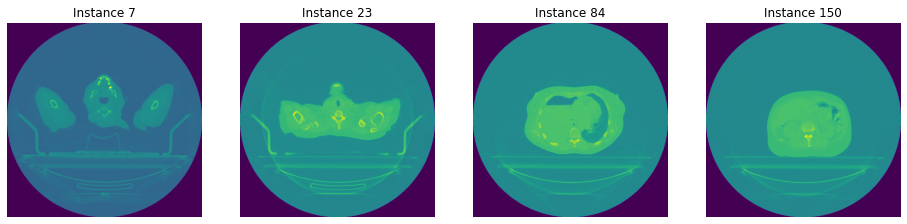

In [ ]:
#@title View Some Instances

# Here, you can view some instances from the 3D image
visualize_instances(voxels=DI, num_to_view=4, shuffle=True)

## Image Processing

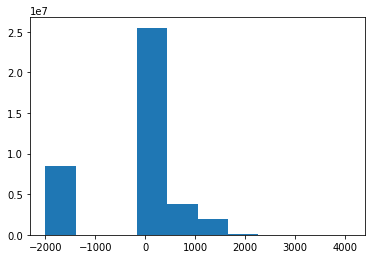

In [ ]:
#@title Color Histogram

plt.hist(DI.reshape(-1))
plt.show()



Now, we would like to rescale and normalize the voxels to [0, 1] range and then get a binary mask to find voxels in bones.

Pay extra attention to the extremely small values (as shown in the previous histogram), they usually represent missing values. So, removing them completely might be a good idea. Other methods could also work.

You can do anything you like to normalize them. An easy solution is use the maximum value and the minimum value.

In [ ]:
#@title Rescale and Create Binary Mask

print("Before rescaling, each pixel ranges from %d to %d" % (
    np.min(image), np.max(image)))

# First, rescale DI values to [0,1]. 

difference = np.max(image)
#DI = DI/difference   # TODO
#print(DI)
DI = DI/(np.max(DI)-np.min(DI))

print(np.max(DI))
"""
for some in range(152):
  DI[some] = (DI[some]-np.min(DI))/(np.max(DI)-np.min(DI))
"""
"""
for filename in files:
  data = dicom.dcmread(filename)

  image = data.pixel_array
  instance_id = int(data.InstanceNumber)
  image = image/np.max(DI)
  DI[instance_id - 1, :, :] = image
"""

print(DI)

#print("After rescaling, each pixel ranges from %d to %d" % (
 #   np.min(image), np.max(image)))
#print(DI)

# Create a mask based on a threshold
threshold = 0.18
masks = DI > threshold


Before rescaling, each pixel ranges from -2000 to 2685
0.671862182116489
[[[-0.32813782 -0.32813782 -0.32813782 ... -0.32813782 -0.32813782
   -0.32813782]
  [-0.32813782 -0.32813782 -0.32813782 ... -0.32813782 -0.32813782
   -0.32813782]
  [-0.32813782 -0.32813782 -0.32813782 ... -0.32813782 -0.32813782
   -0.32813782]
  ...
  [-0.32813782 -0.32813782 -0.32813782 ... -0.32813782 -0.32813782
   -0.32813782]
  [-0.32813782 -0.32813782 -0.32813782 ... -0.32813782 -0.32813782
   -0.32813782]
  [-0.32813782 -0.32813782 -0.32813782 ... -0.32813782 -0.32813782
   -0.32813782]]

 [[-0.32813782 -0.32813782 -0.32813782 ... -0.32813782 -0.32813782
   -0.32813782]
  [-0.32813782 -0.32813782 -0.32813782 ... -0.32813782 -0.32813782
   -0.32813782]
  [-0.32813782 -0.32813782 -0.32813782 ... -0.32813782 -0.32813782
   -0.32813782]
  ...
  [-0.32813782 -0.32813782 -0.32813782 ... -0.32813782 -0.32813782
   -0.32813782]
  [-0.32813782 -0.32813782 -0.32813782 ... -0.32813782 -0.32813782
   -0.32813782]


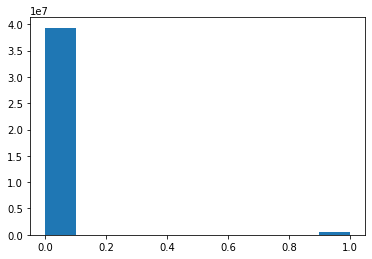

In [ ]:
#@title Histogram after Rescaling

# This block helps you understand the results after rescaling
plt.hist(masks.astype(float).reshape(-1))
plt.show()

In [ ]:
#@title Morphology

# Part 1: Finish the Sphere Function
def create_sphere_kernel(radius):
  """Create a sphere kernel with input radius.

  Args:
    radius (int): the radius of the desired kernel.

  Raises:
    ValueError: if radius is not positive, return value error.

  Returns:
    kernel (np.array): a 3D matrix with "radius * 2 + 1" in each dimension that
      defines the disk kernel.
  """


  if radius < 1:
    raise ValueError("We want a positive radius size, but got %d" % radius)
  
  radius = int(radius)
  dim = 2 * radius + 1
  center = (dim // 2, dim // 2, dim//2)  
  kernel = np.zeros((dim, dim, dim), dtype=np.uint8)

  # Iterate through each location to assign 1 for the disk region.  
  for i in range(dim):
    for j in range(dim):
      for k in range(dim):
   
        dist_to_center = np.sqrt((i - center[0]) ** 2 + (j - center[1]) ** 2 + (k - center[2]) ** 2)
        #print(dist_to_center)
        if dist_to_center <= radius:
          kernel[i, j, k] = 1
  return kernel
  
  raise NotImplementedError
  sphere = None
  return sphere



print(create_sphere_kernel(4))
print(masks)


masks = skimage.morphology.erosion(masks, create_sphere_kernel(1))
#masks = skimage.morphology.dilation(masks, create_sphere_kernel(2))
masks = skimage.morphology.closing(masks, create_sphere_kernel(2))
values = masks

[[[0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0]
  [0 0 0 1 1 1 0 0 0]
  [0 0 1 1 1 1 1 0 0]
  [0 0 1 1 1 1 1 0 0]
  [0 0 1 1 1 1 1 0 0]
  [0 0 0 1 1 1 0 0 0]
  [0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0]
  [0 0 0 1 1 1 0 0 0]
  [0 0 1 1 1 1 1 0 0]
  [0 1 1 1 1 1 1 1 0]
  [0 1 1 1 1 1 1 1 0]
  [0 1 1 1 1 1 1 1 0]
  [0 0 1 1 1 1 1 0 0]
  [0 0 0 1 1 1 0 0 0]
  [0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0]
  [0 0 1 1 1 1 1 0 0]
  [0 1 1 1 1 1 1 1 0]
  [0 1 1 1 1 1 1 1 0]
  [0 1 1 1 1 1 1 1 0]
  [0 1 1 1 1 1 1 1 0]
  [0 1 1 1 1 1 1 1 0]
  [0 0 1 1 1 1 1 0 0]
  [0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 1 0 0 0 0]
  [0 0 1 1 1 1 1 0 0]
  [0 1 1 1 1 1 1 1 0]
  [0 1 1 1 1 1 1 1 0]
  [1 1 1 1 1 1 1 1 1]
  [0 1 1 1 1 1 1 1 0]
  [0 1 1 1 1 1 1 1 0]
  [0 0 1 1 1 1 1 0 0]
  [0 0 0 0 1 0 0 0 0]]



## Visualize Results

TODO hint: look at all the thresholded results, try to find a bounding box to remove the background noise

You may need to try different thresholds and then visualize the results below.




In [ ]:
#@title Find Bounding Box

# Finding a good bounding box for the bones in the rib cage 
# area and the shoulder area.

cleanmask = values[:, 100:380, 100:400]


Now, your results should be all in the `cleanmask` variable.

So, let's visualize the results here!

Text(0.5, 1.0, 'Left View')

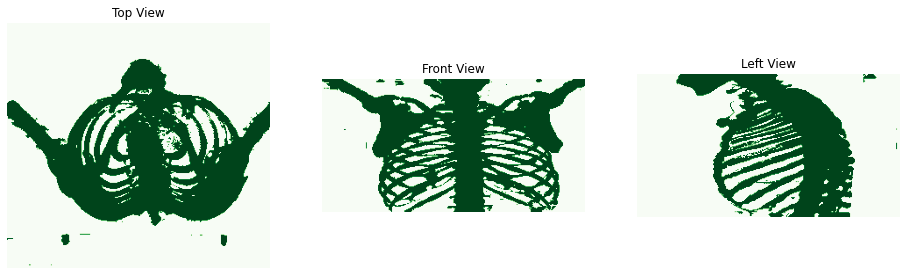

In [ ]:
#@title Visualize in 2D
cmap = "Greens"

plt.figure(figsize=(16, 8)) 

plt.subplot(1, 3, 1)
img = np.max(cleanmask, axis=0)
plt.imshow(img, cmap=cmap)
plt.axis("off")
plt.title("Top View")

plt.subplot(1, 3, 2)
img = np.max(cleanmask, axis=1)
plt.imshow(img, cmap=cmap)
plt.axis("off")
plt.title("Front View")

plt.subplot(1, 3, 3)
img = np.max(cleanmask, axis=2)
plt.imshow(img, cmap=cmap)
plt.axis("off")
plt.title("Left View")

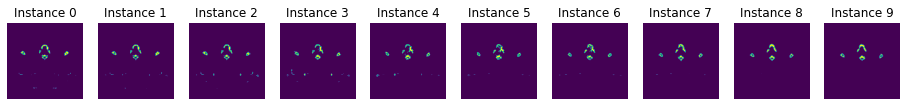

In [ ]:
#@title Visualize Thresholded Results
visualize_instances(voxels=masks, num_to_view=10, shuffle=False)

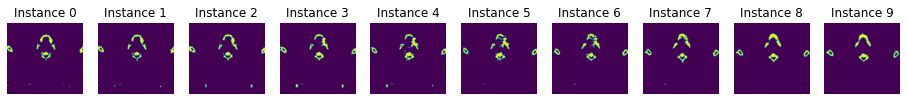

In [ ]:
#@title Visualize Cleaned Mask
visualize_instances(voxels=cleanmask, num_to_view=10, shuffle=False)

### Discussing the results

- How is the result?

  With many trial and error cases, I considered the threshold to be 0.18. With the maximum value of DI falling around 0.6, it made sense to take a threshold that allows to pass most of the data, hence the threshold is so low. From the results, in the top view it seems like there's an issue with the sternal angle of the person. With the bone being askewed towards one side, it's quite visible in the top view. Apart from that, the rest of the chest area seems healthy, with the costal cartillages intact, without a noticeable fracture. 
To achieve this result, I did morphological operations of erosion and closing. Erosion to clean out the extra unnecessary data in the result, and closing to join the boundaries to form a perfect closed structure of the bones. The radius size for the kernels used in these morphological processes were determined by trial and error as well as by intuition. 

## 3D Interactive Visualization

In this block, play around with your voxel results.


In [ ]:
#@title Create Mesh Grids for Voxels


downsample_ratio = 4 #@param {type:"integer"}


# Note: the 3D plot is very slow. So, use the above 
# 2D block first. When you feel comfortable drawing 3D figures, then 
# run this block.

# Rotate to a comfortable angle
rotated = np.swapaxes(cleanmask, 0, 2)
rotated = rotated[:, :, ::-1]

# Downsample
downsampled = rotated[::downsample_ratio, 
                      ::downsample_ratio, 
                      ::downsample_ratio]

# Setup Meshgrid
ux = np.arange(0, downsampled.shape[0])
uy = np.arange(0, downsampled.shape[1])
uz = np.arange(0, downsampled.shape[2])
X, Y, Z = np.meshgrid(ux, uy, uz, indexing='ij')
values = (downsampled > 0) * 255.0

In [ ]:
#@title Plot the 3D Meshgrid
print("Meshgrid Shape:", values.shape)

fig = go.Figure(data=go.Isosurface(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    isomin=10,
    isomax=50,
    surface_count=5, # number of isosurfaces, 2 by default: only min and max
    colorbar_nticks=5, # colorbar ticks correspond to isosurface values
    caps=dict(x_show=False, y_show=False)
    ))
fig.show()

Meshgrid Shape: (75, 70, 38)
